# Obligatorisk innlevering 2 - oppgave 1

Denne oppgaven tar for seg et datasett fra Food Mart, som er en nærbutikkjede i USA. Food Mart har i dette datasettet samlet endel data i forbindelse med mediekampanjer. Din oppgave er å forutsi kostnadene for mediekampanjer i matvaremarkedet på grunnlag av funksjonene som tilbys.

In [1]:
# Importer resten av pakkene du trenger her:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett1.csv")
# Her deler jeg datasettet inn i egenskaper (X) og target (y)
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)
# PS: Ikke endre denne kodecellen!

In [3]:
# Lagt inn mer forklaring til koden ovenfor - hentet fra ChatGPT
# Her deler jeg datasettet inn i egenskaper (features) (X) 
# og target (the cost - i dette tilfelle kostnad av mediekampanjer) (y)

# This line extracts the input variables (features) from the DataFrame df. 
# It uses the .iloc method to select all rows and all columns except the last one (specified by [:-1]). 
# The input variables are typically the independent variables used to make predictions.
X = df.iloc[:,:-1]

#This line extracts the target variable (cost) from the DataFrame df. 
# It uses .iloc to select all rows and only the last column (specified by [:,-1]). 
# The target variable is the dependent variable that you want to predict.
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

#### Oppgave 1.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? 

Begrunn svaret

In [11]:
df.head() #Se på hva datasettet inneholder

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79


In [14]:
df #51363 rows × 16 columns

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51358,3.70,2.0,4.0,4.0,1.0,10.40,1.0,1.0,18.0,34452.0,1.0,0.0,0.0,0.0,1.0,147.17
51359,10.36,4.0,2.0,0.0,2.0,9.43,0.0,0.0,20.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51360,11.19,3.0,3.0,0.0,3.0,18.50,0.0,0.0,5.0,30797.0,1.0,1.0,1.0,1.0,1.0,92.57
51361,3.78,3.0,1.0,1.0,2.0,19.80,0.0,1.0,8.0,23598.0,0.0,0.0,0.0,0.0,1.0,135.92


In [16]:
df.columns

Index(['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist',
       'cost'],
      dtype='object')

In [22]:
X.describe()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
count,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000,51363.000000
mean,6.531792,3.091194,2.538111,0.832019,2.199424,13.805512,0.558437,0.351148,18.856550,27979.153593,0.612367,0.353776,0.588011,0.588011,0.561825
std,3.464902,0.827293,1.489316,1.303775,1.109080,4.622431,0.496578,0.477334,10.263746,5701.145280,0.487215,0.478145,0.492198,0.492198,0.496168
min,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.800000,3.000000,1.000000,0.000000,1.000000,9.700000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.940000,3.000000,3.000000,0.000000,2.000000,13.600000,1.000000,0.000000,19.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000
75%,8.640000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,30797.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000


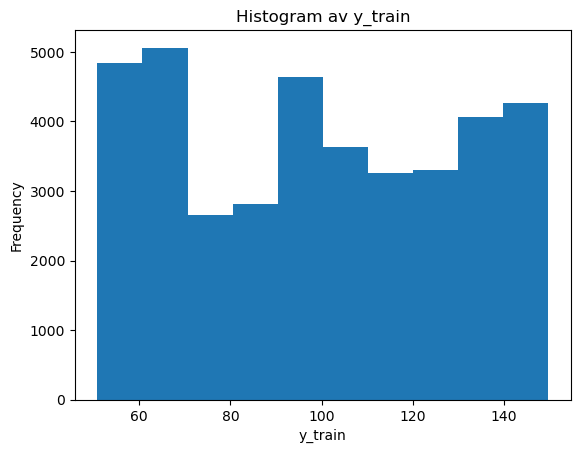

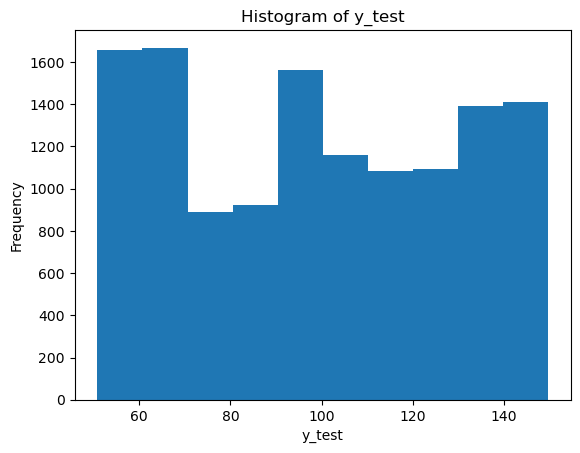

In [4]:
#TODO: visualiser y_train og y_test i et histogram
# y_train
plt.hist(y_train)
plt.title("Histogram av y_train")
plt.ylabel(r'Frequency')
plt.xlabel(r'y_train')
plt.show()

# y_test
plt.hist(y_test)
plt.title("Histogram of y_test")
plt.ylabel(r'Frequency')
plt.xlabel(r'y_test')
plt.show()


**Svar:**

Dette er ett regresjons problem. Vi skal prøve å forutsi en kontinuerlig verdi y (som i dette tilfellet er kostnadene for mediekampanjer) - dvs variabelen cost basert på de andre input variablene i datasettet (X).
Klassifikasjon problemer løser problemer av type spørsmål: ja/nei, solgt/ikke solgt, hund/katt.

Ved å se på de 2 histogrammene ser vi at vi har "kontinuerlige" tall verdier.

Legger merke til at y_test har mye mindre verdier enn y_train.


#### Oppgave 1.2) 

fullfør funksjonen under slik at den tar inn både egenskapene og target, legger disse sammen i samme matrise igjen og visualiser dataene som en korrelasjonsmatrise (poenget er at du skal kunne se hvordan egenskapene korrelerer med target).

* Beskriv hvilke egenskaper du ser korrelerer mest med target

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def korrelasjonsmatrise(X,y):
    X_temp = X.copy()
    y_temp = y.copy()
    X_temp["Target"] = y_temp
    #TODO: Fullfør koden

    correlation_matrix = X_temp.corr()
    # Create a heatmap
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Korrelasjonsmatrise')
    plt.show()

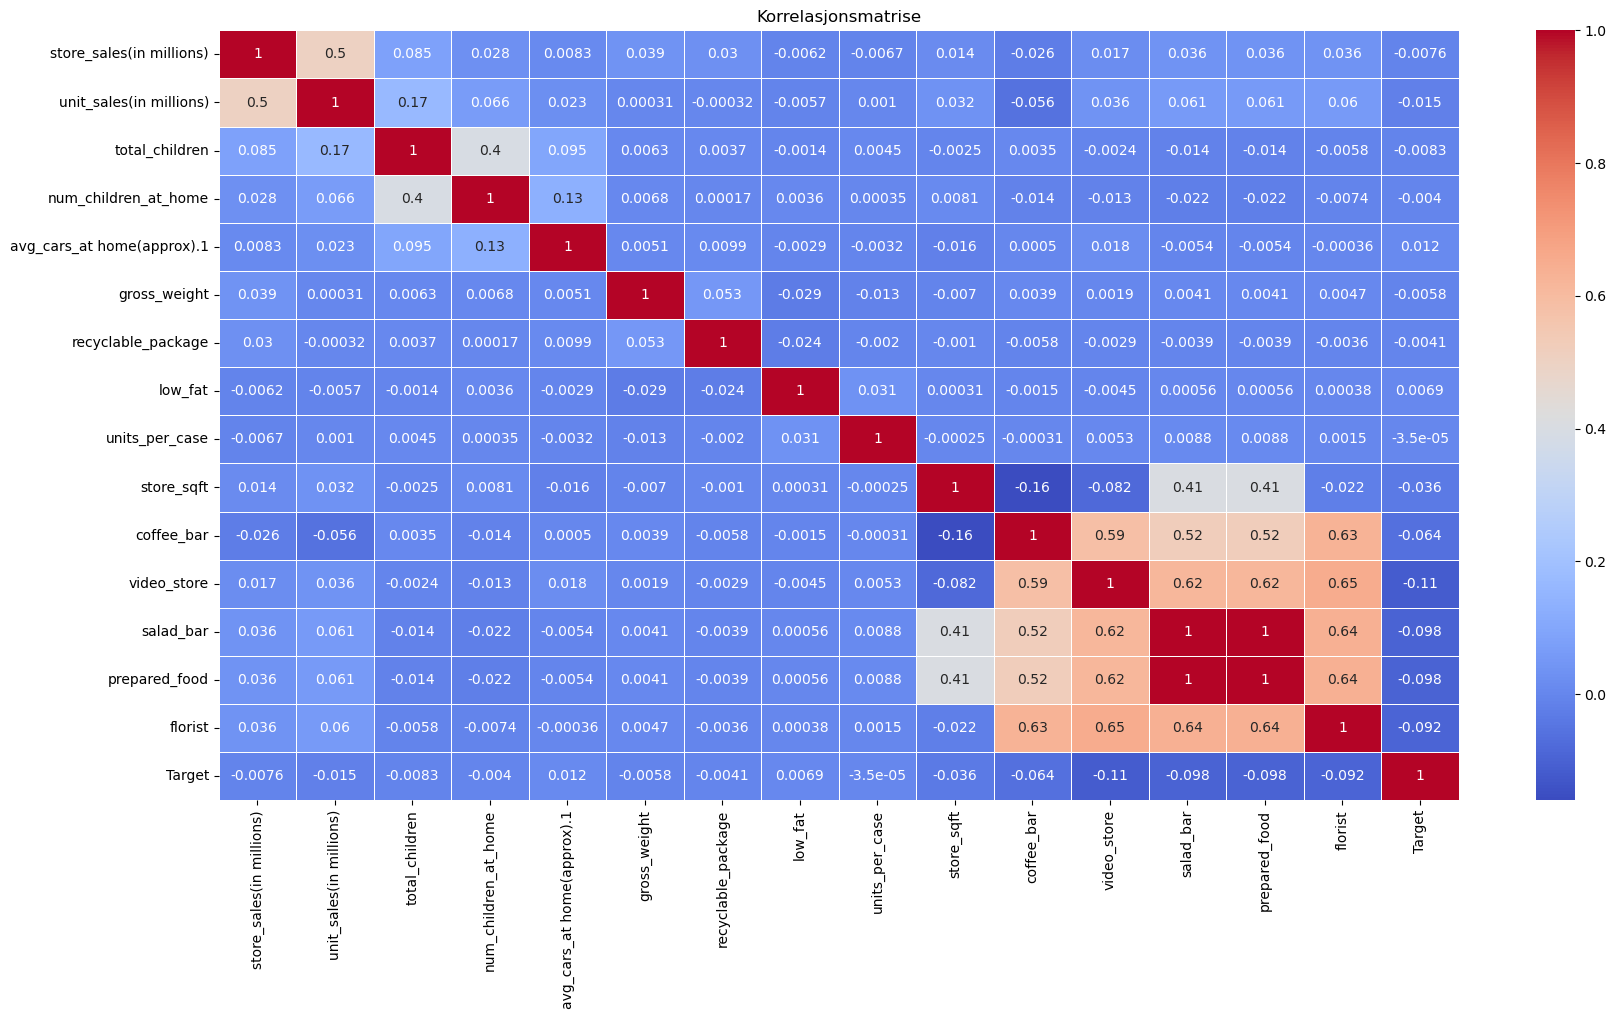

In [20]:
korrelasjonsmatrise(X_train,y_train)

**Svar:**
Her er det svært lite som korrelerer med target... ingenting vil jeg si.
Derimot ser det ut som at:

coffee_bar korrelerer med florist
Video_store med florist
Salad_bar med florist
prepared_food med florist

Pluss noen til i klyngen som man ser ovenfor

#### Oppgave 1.3) 
Velg en modellarkitektur (gjerne fra Scikit-Learn) og gjør et strukturert hyperparametersøk. 
* Gjør et søk på minst 3 paramtere og minst 2 verdier pr parameter
* Bruk 3-folds kryssvalidering for hver parameterkombinasjon
* Velg en metrikk som passer for målet (tips: "neg_mean_squared_error" i sklearn) 
* Skriv ut den parameterkobinasjonen som ga den beste skåren, samt skåren. Kommenter resultatet

In [6]:
#TODO: Utfør hyperparametersøk for en modell

**Svar:**

*< ditt tekstsvar her >*

#### Oppgave 1.4) 
Bruk hyperparameterkombinasjonen fra oppgave 1.3 og kryssvalider den modellen på nytt med K >= 5 
* Logg "mean absolute error" og "mean squared error" for hver kryssvalideringsrunde
* Oppgi gjennomsnitt og standardavvik for "mean absolute error" og "mean squared error" etter kryssvalideringen og kommenter resultatet
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i treningsdataene? 

In [7]:
#TODO: Utfør kryssvalidering med de optimale parameterene fra forrige oppgave og logg mean_absolute_error og mean_squared_error

In [8]:
#TODO: Beregn gjennomsnitt og standard avvik for mean_absolute_error og mean_squared_error og beregn hvor stor den 
# gjennomsnittlige feilen er i forhold til den gjennomsnittlige prisen for markedskampanjen (target) i prosent

**Svar:**

*< ditt tekstsvar her >*

#### Oppgave 1.5) 
Tren modellen en siste gang på alle treningsdataene og gjør prediksjon på testdataene (bruk de optimale parametrene fra oppgave 1.3)
* Hvor stor er den gjennomsnittlige feilen på prediksjonen sammenlignet med gjennomsnittlig faktisk pris i testdataene? 

In [9]:
#TODO: Tren modellen på alle treningsdata og utfør prediksjon på testdataene

**Svar:**

*< ditt tekstsvar her >*